In [ ]:
# Imports and Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/CMSC320 Project/

/content/drive/.shortcut-targets-by-id/1g2WDnYtwYUjrEX205HTh8ABD7cyoW0Tf/CMSC320 Project


In [ ]:
final_df = pd.read_csv("data/final.csv")

In [ ]:
final_df = final_df.drop(columns="Unnamed: 0")

In [ ]:
final_df = final_df.drop(columns=["energy_median", "energy_mean", "energy_max", "energy_count", "energy_std", "energy_min"])

In [ ]:
final_df = final_df.drop(columns="season")
final_df["date"] = pd.to_datetime(final_df["date"])

In [ ]:
weather_df = pd.read_csv("data/weather_daily_darksky.csv")
weather_df["date"] = pd.to_datetime(pd.to_datetime(weather_df["temperatureHighTime"]).dt.date)
weather_df["temperatureAverage"] = (weather_df["temperatureLow"] + weather_df["temperatureHigh"]) / 2
weather_df = weather_df[["date", "temperatureAverage"]]
weather_df

,date,temperatureAverage
0,2011-11-11,10.870
1,2011-12-11,5.840
2,2011-12-27,9.180
3,2011-12-02,6.845
4,2011-12-24,7.690
...,...,...
877,2014-01-26,5.795
878,2014-02-27,6.870
879,2014-03-09,12.005
880,2014-02-12,6.485


In [ ]:
sample_df = final_df[final_df["Acorn_category"] == "Established"]
sample_df = sample_df.drop(columns="LCLid")
sample_df = sample_df.groupby("date")["energy_sum"].mean().reset_index()
sample_df['day_of_year'] = sample_df['date'].dt.dayofyear
sample_df['sin_day'] = np.sin(2 * np.pi * sample_df['day_of_year'] / 365)
sample_df['cos_day'] = np.cos(2 * np.pi * sample_df['day_of_year'] / 365)
sample_df = sample_df.drop(columns="day_of_year")
sample_df['day_of_week'] = sample_df['date'].dt.dayofweek
sample_df['sin_day_of_week'] = np.sin(2 * np.pi * sample_df['day_of_week'] / 7)
sample_df['cos_day_of_week'] = np.cos(2 * np.pi * sample_df['day_of_week'] / 7)
sample_df = sample_df.drop(columns="day_of_week")
sample_df["is_weekend"] = sample_df["date"].apply(lambda x: int(x.dayofweek > 4))
# sample_df['month_of_year'] = sample_df['date'].dt.month
# sample_df['sin_month'] = np.sin(2 * np.pi * sample_df['month_of_year'] / 12)
# sample_df['cos_month'] = np.cos(2 * np.pi * sample_df['month_of_year'] / 12)
# sample_df['is_summer'] = sample_df['month_of_year'].isin([6, 7, 8]).astype(int)
# sample_df['is_winter'] = sample_df['month_of_year'].isin([12, 1, 2]).astype(int)
# sample_df = sample_df.drop(columns="month_of_year")
sample_df['time_since_start'] = (sample_df['date'] - sample_df['date'].min()).dt.days
# sample_df['time_since_start_squared'] = sample_df['time_since_start']**2
# sample_df = sample_df.drop(columns="time_since_start")
sample_df = pd.merge(left = sample_df, right = weather_df, left_on = "date", right_on = "date")
sample_df = sample_df.dropna()
sample_df

,date,energy_sum,sin_day,cos_day,sin_day_of_week,cos_day_of_week,is_weekend,time_since_start,temperatureAverage
0,2011-11-23,11.551500,-0.608477,0.793572,0.974928,-0.222521,0,0,9.300
1,2011-11-24,10.654900,-0.594727,0.803928,0.433884,-0.900969,0,1,11.320
2,2011-11-25,11.062214,-0.580800,0.814046,-0.433884,-0.900969,0,2,9.640
3,2011-11-26,12.207176,-0.566702,0.823923,-0.974928,-0.222521,1,3,12.275
4,2011-11-27,12.611000,-0.552435,0.833556,-0.781831,0.623490,1,4,7.425
...,...,...,...,...,...,...,...,...,...
808,2014-02-23,12.498105,0.801361,0.598181,-0.781831,0.623490,1,823,9.965
809,2014-02-24,11.507970,0.811539,0.584298,0.000000,1.000000,0,824,11.240
810,2014-02-25,11.384361,0.821477,0.570242,0.781831,0.623490,0,825,7.240
811,2014-02-26,11.314600,0.831171,0.556017,0.974928,-0.222521,0,826,8.650


<Axes: xlabel='date'>

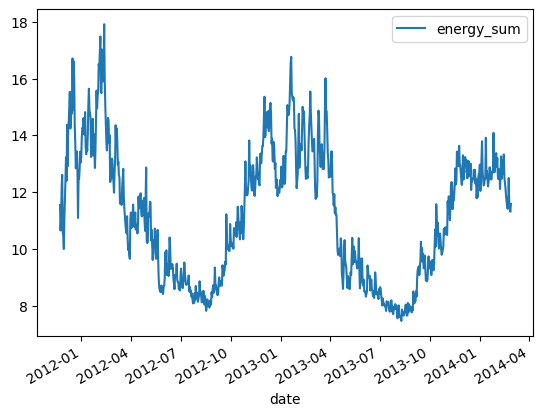

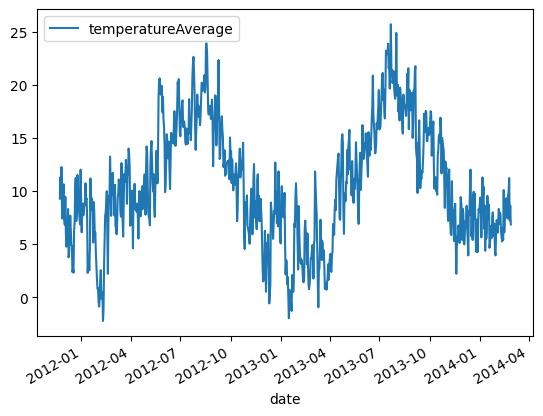

In [ ]:
sample_df.plot("date", "energy_sum")
sample_df.plot("date", "temperatureAverage")

In [ ]:
dataset = sample_df.drop(columns=["date"])

In [ ]:
train_size = int(len(dataset) * 0.7)
dataset_train, dataset_test = dataset[:train_size], dataset[train_size:]

scaler = MinMaxScaler()
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

In [ ]:
def create_windows(dataset, look_back, forecast_steps):
    X, y = [], []
    for i in range(len(dataset) - look_back - forecast_steps):
        X.append(dataset[i:i+look_back])
        y.append(dataset[i+look_back:i+look_back+forecast_steps, 0])
    return np.array(X), np.array(y)

look_back, forecast_steps = 30, 30
X_train, y_train = create_windows(dataset_train, look_back, forecast_steps)
X_test, y_test = create_windows(dataset_test, look_back, forecast_steps)

In [ ]:
X_train[0]

array([[3.69301547e-01, 1.95758748e-01, 8.96783893e-01, 1.00000000e+00,
        3.56895868e-01, 0.00000000e+00, 0.00000000e+00, 4.40681209e-01],
       [2.80362056e-01, 2.02633903e-01, 9.01962165e-01, 7.22520934e-01,
        5.55111512e-17, 0.00000000e+00, 1.72413793e-03, 5.17986988e-01],
       [3.20766165e-01, 2.09597174e-01, 9.07021325e-01, 2.77479066e-01,
        0.00000000e+00, 0.00000000e+00, 3.44827586e-03, 4.53693073e-01],
       [4.34342286e-01, 2.16646498e-01, 9.11959872e-01, 0.00000000e+00,
        3.56895868e-01, 1.00000000e+00, 5.17241379e-03, 5.54535017e-01],
       [4.74400129e-01, 2.23779786e-01, 9.16776345e-01, 9.90311321e-02,
        8.01937736e-01, 1.00000000e+00, 6.89655172e-03, 3.68924608e-01],
       [2.75155145e-01, 2.30994923e-01, 9.21469314e-01, 5.00000000e-01,
        1.00000000e+00, 0.00000000e+00, 8.62068966e-03, 4.77803291e-01],
       [2.60970815e-01, 2.38289773e-01, 9.26037391e-01, 9.00968868e-01,
        8.01937736e-01, 0.00000000e+00, 1.03448276e-02, 4.

In [ ]:
y_train[0]

array([0.52130753, 0.55589695, 0.48829938, 0.32398312, 0.4552611 ,
       0.46048747, 0.49643915, 0.55504812, 0.5176438 , 0.54046823,
       0.60772008, 0.63852839, 0.63514627, 0.67257971, 0.65163017,
       0.6135555 , 0.69329732, 0.57683904, 0.54641546, 0.57256151,
       0.55913344, 0.62039105, 0.72078353, 0.77495919, 0.69794637,
       0.69068901, 0.67252085, 0.53703461, 0.60186802, 0.56586173])

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (509, 30, 8)
y_train shape: (509, 30)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1:]), kernel_regularizer=l2(0.0001)),
    Dense(30)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1816 - mae: 0.3483
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0833 - mae: 0.2284
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0466 - mae: 0.1768
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0298 - mae: 0.1350
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0207 - mae: 0.1080
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0160 - mae: 0.0934
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0149 - mae: 0.0899
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0139 - mae: 0.0860
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0124 - mae: 0.0807
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119 - mae: 0.0785
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0122 - mae: 0.0801
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0116 - mae: 0.0774
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms

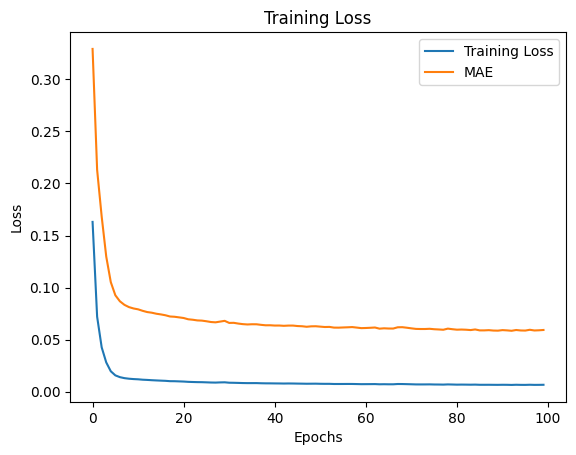

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['mae'], label='MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - mae: 0.0517  


[0.005311008542776108, 0.05515902116894722]

In [ ]:
model.evaluate(X_train, y_train)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - mae: 0.0629


[0.0065142991952598095, 0.05849749967455864]

In [ ]:
train_predict = model.predict(X_train)
train_predict = np.array([scaler.inverse_transform(
    np.hstack([predict.reshape(-1, 1), np.zeros((predict.shape[0], X_train.shape[-1] - 1))])
)[:, 0] for predict in train_predict]).tolist()
test_predict = model.predict(X_test)
test_predict = np.array([scaler.inverse_transform(
    np.hstack([predict.reshape(-1, 1), np.zeros((predict.shape[0], X_train.shape[-1] - 1))])
)[:, 0] for predict in test_predict]).tolist()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [ ]:
y_train_inverse = np.array([scaler.inverse_transform(
    np.hstack([train.reshape(-1, 1), np.zeros((train.shape[0], X_train.shape[-1] - 1))])
)[:, 0] for train in y_train]).tolist()
y_test_inverse = np.array([scaler.inverse_transform(
    np.hstack([test.reshape(-1, 1), np.zeros((test.shape[0], X_train.shape[-1] - 1))])
)[:, 0] for test in y_test]).tolist()

In [ ]:
y_train.shape

(509, 30)

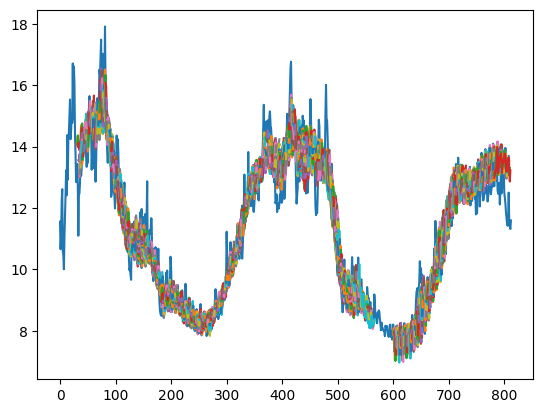

In [ ]:
plt.plot(np.arange(len(dataset["energy_sum"])), dataset["energy_sum"], label="Original Data")
for i in range(len(train_predict)):
  plt.plot(np.arange(i+look_back, i+look_back+forecast_steps), train_predict[i])
for i in range(len(train_predict), len(train_predict) + len(test_predict)):
  plt.plot(np.arange(i+2*look_back+forecast_steps, i+2*look_back+2*forecast_steps), test_predict[i-len(train_predict)])
plt.show()

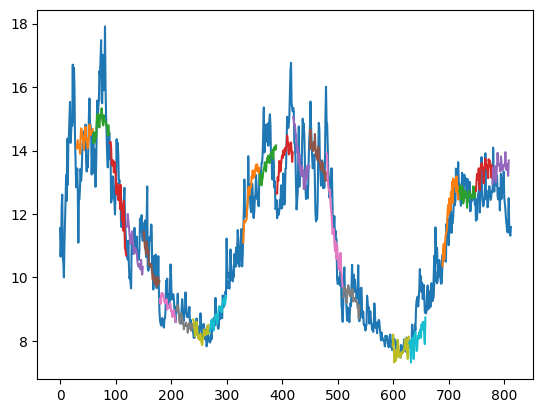

In [ ]:
plt.plot(np.arange(len(dataset["energy_sum"])), dataset["energy_sum"], label="Original Data")
for i in range(0, len(train_predict), 30):
  plt.plot(np.arange(i+look_back, i+look_back+forecast_steps), train_predict[i])
for i in range(len(train_predict), len(train_predict) + len(test_predict), 30):
  plt.plot(np.arange(i+2*look_back+forecast_steps, i+2*look_back+2*forecast_steps), test_predict[i-len(train_predict)])
plt.show()

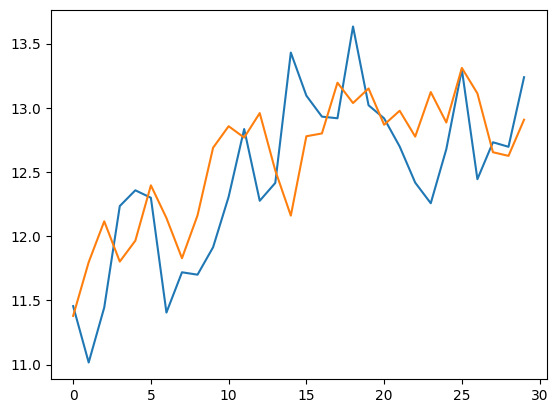

In [ ]:
plt.plot(np.arange(30), y_test_inverse[100])
plt.plot(np.arange(30), test_predict[100])
plt.show()

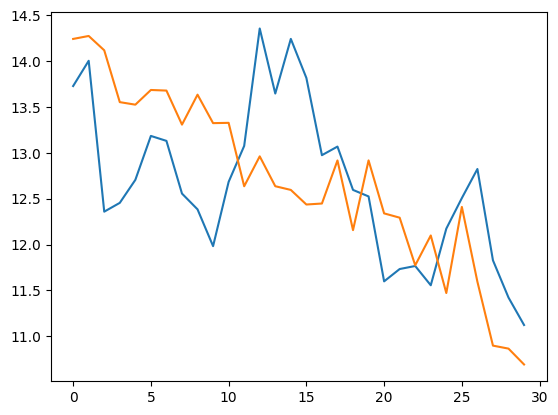

In [ ]:
plt.plot(np.arange(30), y_train_inverse[60])
plt.plot(np.arange(30), train_predict[60])
plt.show()